In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append('/home/jovyan/work')
# https://wikitech.wikimedia.org/wiki/Analytics/Data_Lake/Edits/Mediawiki_history_dumps#Technical_Documentation

In [4]:
import numpy as np
import pandas as pd
from scripts.config import DUMPS_PATH, PRE_PATH
#from scripts.filter_mw_dumps import process_lang_history
from mw.lib import title as mw_t

In [5]:
import swifter

In [6]:
column_names = np.loadtxt(f'mediawiki_history_columns.txt', dtype=str)

DTYPES = [str, str, str, str, str,
          'Int64',
          str, str,
          object, object, object, object, object, object,
          "boolean", "boolean", "boolean", "boolean",
          str, str, str,
          'Int64', 'Int64', 'Int64',
          str, str, 'Int64',
          "boolean", 'Int64',
          "boolean", "boolean", "boolean",
          str, str,
          'Int64', 'Int64', 'Int64',
          str, str,
          object, object, object, object, object, object,
          "boolean", "boolean", "boolean", "boolean",
          str, str, str,
          'Int64', 'Int64',
          "boolean",
          object,
          "boolean",
          'Int64', 'Int64',
          str, str, str,
          "boolean",
          str,
          "boolean",
          'Int64', 'Int64',
          "boolean", "boolean",
          object]

DTYPE_DICT = dict(zip(column_names, DTYPES))

In [7]:
rel_cols = ['event_entity', 'revision_id', 'revision_parent_id',
               'revision_text_bytes', 'revision_text_bytes_diff',
               'revision_is_identity_revert', 'revision_is_identity_reverted',
               'event_timestamp', 'page_id', 'page_title', 'page_title_historical',
               'page_namespace_historical', 'event_user_id', 'page_namespace',
               'page_revision_count', 'page_is_redirect', 'page_is_deleted',
               'event_user_text_historical', 'event_user_text',
               'event_user_is_bot_by_historical', 'event_user_groups_historical',
               'event_user_revision_count', 'event_user_registration_timestamp',
               'event_user_creation_timestamp']

In [ ]:
df_en = process_lang_history('en', column_names, DTYPE_DICT, path=f'../{DUMPS_PATH}', 
                             ending='tsv.bz2', years=list(range(2012, 2024)), usecols=rel_cols)

In [ ]:
df_en_2023 = process_lang_history('en', column_names, DTYPE_DICT, path=f'../{DUMPS_PATH}', 
                                  ending='tsv.bz2', years=list(range(2023, 2024)), usecols=rel_cols)
df_en = pd.concat([df_en, df_en_2023]).reset_index(drop=True)



In [ ]:
df_en['page_title_norm'] = df_en.page_title.swifter.apply(lambda title: mw_t.normalize(str(title)) if not pd.isna(title) else pd.NA)
df_en['page_title_historical_norm'] = df_en.page_title_historical.swifter.apply(lambda title: mw_t.normalize(str(title)) if not pd.isna(title) else pd.NA)

df_en.to_csv(f'../datasets/wiki_pp/en-complete-2012-2023.tsv.bz2', sep='\t', index=False)

In [ ]:
df_en = pd.read_csv(f'../datasets/wiki_pp/en-complete-2012-2023.tsv.bz2', sep='\t')

In [147]:
df_treat = pd.read_csv('../data/experiment/df_candidate_articles.csv')


In [23]:
treat_titles = set(df_treat.norm_title.values)

In [ ]:
df_filtered = df_en[df_en.page_title_historical_norm.isin(treat_titles) | df_en.page_title_norm.isin(treat_titles)]
df_filtered.to_csv(f'../../datasets/wiki_pp/en-filtered-2012-2023.tsv.bz2', sep='\t', index=False)

# now get revisions around relevant timestamp

In [224]:
from scripts.filter_mw_dumps import filter_data_around_timestamp

In [ ]:
df_exp = pd.read_csv('../data/experiment/df_experiment_articles.csv')
df_exp.treated_id = pd.to_numeric(df_exp.treated_id, errors='coerce')
df_exp['dummy'] = 1


In [199]:
df_filtered.page_title_historical_norm = df_filtered.page_title_historical_norm.astype(str)
df_filtered.event_timestamp = pd.to_datetime(df_filtered.event_timestamp, errors='coerce', utc=True)

df_exp.start = pd.to_datetime(df_exp.start, errors='coerce', utc=True)
df_exp.end = pd.to_datetime(df_exp.end, errors='coerce', utc=True)
df_exp.request_timestamp = pd.to_datetime(df_exp.request_timestamp, errors='coerce', utc=True)
df_exp.norm_title = df_exp.norm_title.astype(str)

In [ ]:
df_mw_data_onid = filter_data_around_timestamp(df_filtered, df_exp, filename=None)


In [202]:
df_mw_data = filter_data_around_timestamp(df_filtered, df_exp, filename=None)
#df_mw_data.to_csv('../data/experiment/mw_treated_90.tsv.bz2', index=False)

In [257]:
df_new_name = df_filtered.query('page_title_historical != page_title_norm')

In [319]:
df_mw_data_othername = filter_data_around_timestamp(df_new_name, df_exp, page_title_column='page_title_norm', filename=None)


In [343]:
df_mw_data_combined = pd.concat([df_mw_data, df_mw_data_othername])

In [344]:
df_mw_data_combined[df_mw_data_combined[revision_id].duplicated(keep=False)].sort_values('revision_id').tail()[['revision_id', 'page_title_historical', 'page_title_norm', 'norm_title', 'treated_id']]

,revision_id,page_title_historical,page_title_norm,norm_title,treated_id
70984542,1146666830,Alder_Lake,Alder_Lake,Alder_Lake,85613.0
70984548,1146666903,Alder_Lake,Alder_Lake,Alder_Lake,4785.0
70984548,1146666903,Alder_Lake,Alder_Lake,Alder_Lake,85613.0
71011297,1146985528,Alder_Lake,Alder_Lake,Alder_Lake,85613.0
71011297,1146985528,Alder_Lake,Alder_Lake,Alder_Lake,4785.0


In [ ]:
df_mw_data = pd.read_csv('../data/experiment/mw_treated_90.tsv.bz2')

In [ ]:
#df_filtered = pd.read_csv(f'../../datasets/wiki_pp/en-filtered-2012-2023.tsv.bz2', sep='\t')
df_filtered.revision_id = pd.to_numeric(df_filtered.revision_id, errors='coerce')
df_filtered.revision_parent_id = pd.to_numeric(df_filtered.revision_parent_id, errors='coerce')

df_filtered.page_namespace_historical = pd.to_numeric(df_filtered.page_namespace_historical, errors='coerce')
df_filtered['page_namespace_content'] = (df_filtered.page_namespace_historical % 2) == 0


In [351]:
df_mw_data_combined.page_namespace_historical = pd.to_numeric(df_mw_data_combined.page_namespace_historical, errors='coerce')
df_mw_data_combined['page_namespace_content'] = (df_mw_data_combined.page_namespace_historical % 2) == 0

df_data_content = df_mw_data_combined[df_mw_data_combined.page_namespace_content == True]
df_data_content.event_timestamp = pd.to_datetime(df_data_content.event_timestamp, utc=True, errors='coerce')

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [353]:
df_first_revs_for_all = df_data_content.loc[df_data_content.groupby('treated_id').event_timestamp.idxmin()]
df_first_revs_for_all.revision_parent_id = df_first_revs_for_all.revision_parent_id.astype(int)

df_parent_revs = df_filtered.merge(df_first_revs_for_all,
                             left_on='revision_id', right_on='revision_parent_id', how='left',
                             suffixes=('', '_mrg')).dropna(subset=['revision_parent_id_mrg'])
df_parent_revs = df_parent_revs.query('revision_id != 0').drop_duplicates(subset='revision_id')

In [354]:
df_parent_revs = df_parent_revs[[col for col in df_parent_revs.columns if not col.endswith('_mrg')]]

In [355]:
df_parent_revs['page_namespace_content'] = True
df_parent_revs = df_parent_revs[[col for col in df_parent_revs.columns if not col.endswith('_mrg')]]

In [356]:
df_mw_data_with_parents_ext = pd.concat([df_parent_revs, df_mw_data_combined])
df_mw_data_with_parents_ext.event_timestamp = pd.to_datetime(df_mw_data_with_parents_ext.event_timestamp, errors='coerce', utc=True)
df_mw_data_with_parents_ext = df_mw_data_with_parents_ext.drop_duplicates()

In [362]:
df_new_revision_ids = df_mw_data_with_parents_ext[~df_mw_data_with_parents_ext.revision_id.isin(df_mw_data_with_parents.revision_id.unique())]

In [368]:
df_new_revision_ids[['revision_id', 'revision_parent_id', 'page_title_historical']].to_csv('../data/experiment/new_revids.csv', index=False)

In [ ]:
df_mw_data_with_parents = pd.concat([df_parent_revs, df_mw_data_combined])
df_mw_data_with_parents.event_timestamp = pd.to_datetime(df_mw_data_with_parents.event_timestamp, errors='coerce', utc=True)
df_mw_data_with_parents = df_mw_data_with_parents.drop_duplicates()

In [ ]:
df_mw_data_with_parents_ext[df_mw_data_with_parents_ext.columns[1:]].to_csv('../data/experiment/mw_experiment_90_with_parents-ext.tsv.bz2', index=False)

In [376]:
df_last_rev = df_mw_data_with_parents_ext.loc[df_mw_data_with_parents_ext.groupby('norm_title').event_timestamp.idxmax()]
df_last_rev.page_namespace = pd.to_numeric(df_last_rev.page_namespace.fillna(-1), errors='coerce').astype(int)
df_last_rev.treated_id = df_last_rev.treated_id.astype(int)

df_exp.decision_ts = pd.to_datetime(df_exp.decision_ts, errors='coerce', utc=True)
df_exp.request_timestamp = pd.to_datetime(df_exp.decision_ts, errors='coerce', utc=True)
df_exp.start = pd.to_datetime(df_exp.start, errors='coerce', utc=True)
df_exp.end = pd.to_datetime(df_exp.end, errors='coerce', utc=True)
df_exp_ns0 = df_exp[df_exp.treated_id.isin(df_last_rev.query("page_namespace == 0").treated_id.values)]

In [377]:
df_exp_ns0.to_csv('../data/experiment/df_experiment_articles_ns0-ext.csv', index=False)

In [378]:
df_mw_data_with_parents_ns0 = df_mw_data_with_parents_ext[
    df_mw_data_with_parents_ext.treated_id.isin(df_exp_ns0.treated_id.values)]


In [ ]:
df_mw_data_with_parents_ns0_base = df_mw_data_with_parents[
    df_mw_data_with_parents_ext.treated_id.isin(df_exp_ns0.treated_id.values)]

In [ ]:
11836604

In [380]:
len(df_mw_data_with_parents_ns0)

11836604

In [379]:
df_mw_data_with_parents_ns0[df_mw_data_with_parents_ns0.columns[1:]].to_csv('../data/experiment/mw_experiment_90_with_parents_ns0-ext.tsv.bz2', index=False)

### double check remaining dataset with previous checks

In [ ]:
df_mw_data = filter_data_around_timestamp(df_filtered, df_exp, filename=None)


In [164]:
from scripts.descriptive import plot_rfpp

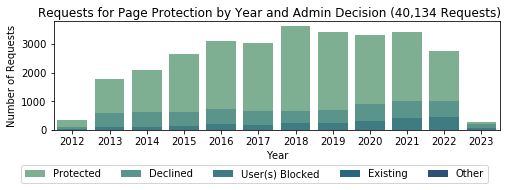

In [161]:
df_rel_rfpp = df_exp_ns0[df_exp_ns0.type != 'spell-not-requested'].copy()
df_rel_rfpp['Status'] = df_rel_rfpp.type.apply(
    lambda s: 'Protected' if s == 'rfpp-protected' else 'Declined' if s == 'rfpp-declined' else 'UserIssue' if s == 'rfpp-userint' else None)

plot_rfpp(df_rel_rfpp, filename=None)

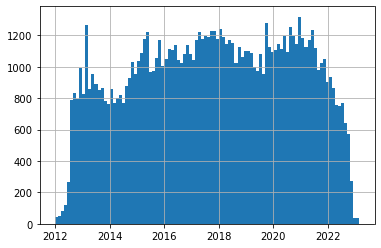

In [40]:
df_parent_revs.event_timestamp = pd.to_datetime(df_parent_revs.event_timestamp, utc=True, errors='coerce')
df_parent_revs.event_timestamp.dt.date.hist(bins=100)

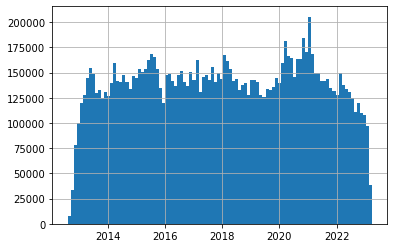

In [72]:
df_mw_exp.event_timestamp.dt.date.hist(bins=100)

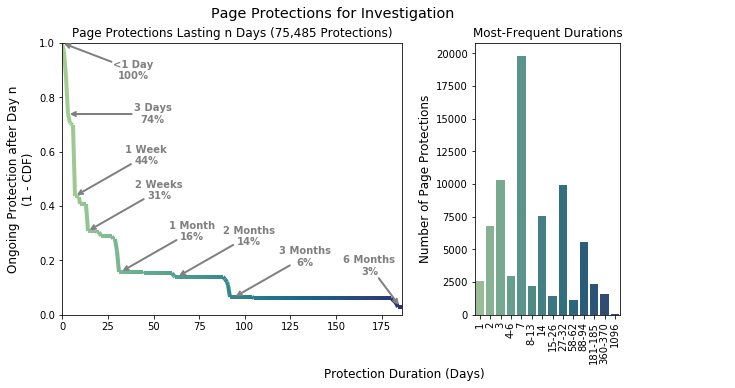

In [181]:
from scripts.descriptive import compute_cdf_and_plot, compute_duration_dfs

df_spells = df_exp_ns0[df_exp_ns0.type.isin(['spell-not-requested', 'rfpp-protected'])].copy()
df_spells.start, df_spells.end = pd.to_datetime(df_spells.start, utc=True), pd.to_datetime(df_spells.end, utc=True)
df_spells['dummy_type'] = 'edit'
df_edit_spells_all, df_prot_survival_all = compute_duration_dfs(df_spells, type_col='dummy_type')
df_cdf_count, df_hist = compute_cdf_and_plot(df_edit_spells_all, title='Page Protections for Investigation', exclude_infinity=True, bins_limit=14)
most_pp = set(df_hist.sort_values('value', ascending=False)[:14].duration_days.values)
def sortby(x):
    try:
        return int(x.split('-')[0])
    except ValueError:
        return float('inf')
hue_order = list(sorted(list(most_pp), key=sortby))

In [ ]:
df_revisions = df_mw_data.revision_id.astype(int).unique()
np.savetxt('../data/experiment/revids_only.csv',df_revisions, fmt='%d')
df_revisions_parents = df_mw_data.revision_parent_id.astype(int).unique()
np.savetxt('../data/experiment/revids_only_parents.csv', df_revisions_parents, fmt='%d')

In [100]:
df_revisions = df_mw_data_with_parents.revision_id.astype(int).unique()
df_revisions_parents = df_mw_data_with_parents.revision_parent_id.astype(int).unique()
df_revisions_all = set(df_revisions) | set(df_revisions_parents)

np.savetxt('../data/experiment/revids_only_content_with_parents.csv', list(df_revisions_all), fmt='%d')